In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, auc, roc_curve

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, \
train_model_cross_val, train_model_test, \
get_feature_importance_cv, get_feature_importance, get_feature_importance10

### Load data

In [3]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_20.json")

### Balance data and split to train and test set

In [4]:
label_name = "phase2"

In [5]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [6]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [8]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(2,2),(2,3), (2,4), (3,3), (3,4)], # limit to trigrams (1,2),(1,1),(1,3), 
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [10]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=5, scoring='f1') #roc_auc

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
done in 5361.443s
Best cross-validation score:  0.9156451612903226
Best parameters set:
	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (2, 4)
	tfidf__norm: 'l2'
	tfidf__use_idf: False


##### Model fitting and evaluation

In [11]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=5)

fitting the best model
Accuracy: 0.9171974522292994

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92        79
           1       0.93      0.90      0.92        78

    accuracy                           0.92       157
   macro avg       0.92      0.92      0.92       157
weighted avg       0.92      0.92      0.92       157


CR: (0.9178861788617887, 0.9170723790976956, 0.9171436690618276, None)

Confusion matrix:
 [[74  5]
 [ 8 70]] 

_______________________


 Accuracy: 91.720 
 Precision: 0.933 
 Recall: 0.897 
 F1: 0.915 
 FPR: 0.063 
 ROC_AUC: 0.917


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [12]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../output/tables/features_svm_cv_full_p2_v2.xlsx', index=True)
df_features_cv.head()

,feature,importance
660,committee concentration,0.440856
141,advisory committee concentration,0.440856
902,considered concentration,-0.407006
4483,spain germany,0.404601
3894,regard right,0.393045


In [13]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.9074333800841514

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      1406
           1       0.12      0.90      0.21        20

    accuracy                           0.91      1426
   macro avg       0.56      0.90      0.58      1426
weighted avg       0.99      0.91      0.94      1426


CR: (0.5600283381973523, 0.9037695590327169, 0.5825526932084308, None)

Confusion matrix:
 [[1276  130]
 [   2   18]] 

_______________________


 Accuracy: 90.743 
 Precision: 0.122 
 Recall: 0.900 
 F1: 0.214 
 FPR: 0.092 
 ROC_AUC: 0.904


In [14]:
evaluate(y_test, y_predict_cv_test)

Accuracy: 0.9074333800841514

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      1406
           1       0.12      0.90      0.21        20

    accuracy                           0.91      1426
   macro avg       0.56      0.90      0.58      1426
weighted avg       0.99      0.91      0.94      1426


CR: (0.5600283381973523, 0.9037695590327169, 0.5825526932084308, None)

Confusion matrix:
 [[1276  130]
 [   2   18]] 

_______________________


 Accuracy: 90.743 
 Precision: 0.122 
 Recall: 0.900 
 F1: 0.214 
 FPR: 0.092 
 ROC_AUC: 0.904


In [15]:
y_predict_cv_test1 = fit_best_model_test(X_test1, y_test1, pipeline_cv)

testing on test set
Accuracy: 0.9

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.90      0.90      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40


CR: (0.9, 0.9, 0.9, None)

Confusion matrix:
 [[18  2]
 [ 2 18]] 

_______________________


 Accuracy: 90.000 
 Precision: 0.900 
 Recall: 0.900 
 F1: 0.900 
 FPR: 0.100 
 ROC_AUC: 0.900


### Model training (with 10-fold CV) using best parameters from GridSearch

In [17]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (2, 4)
	tfidf__norm: 'l2'
	tfidf__use_idf: False


In [18]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (2,4), binary = True, max_df = 0.05, norm = 'l2', use_idf = False))
c = 1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [19]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.9299363057324841

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.93        79
           1       0.99      0.87      0.93        78

    accuracy                           0.93       157
   macro avg       0.94      0.93      0.93       157
weighted avg       0.94      0.93      0.93       157


CR: (0.935935441370224, 0.9295683219733852, 0.9296509022770785, None)

Confusion matrix:
 [[78  1]
 [10 68]] 

_______________________


 Accuracy: 92.994 
 Precision: 0.986 
 Recall: 0.872 
 F1: 0.925 
 FPR: 0.013 
 ROC_AUC: 0.930


In [20]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.9074333800841514

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      1406
           1       0.12      0.90      0.21        20

    accuracy                           0.91      1426
   macro avg       0.56      0.90      0.58      1426
weighted avg       0.99      0.91      0.94      1426


CR: (0.5600283381973523, 0.9037695590327169, 0.5825526932084308, None)

Confusion matrix:
 [[1276  130]
 [   2   18]] 

_______________________


 Accuracy: 90.743 
 Precision: 0.122 
 Recall: 0.900 
 F1: 0.214 
 FPR: 0.092 
 ROC_AUC: 0.904


In [21]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.9

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.90      0.90      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40


CR: (0.9, 0.9, 0.9, None)

Confusion matrix:
 [[18  2]
 [ 2 18]] 

_______________________


 Accuracy: 90.000 
 Precision: 0.900 
 Recall: 0.900 
 F1: 0.900 
 FPR: 0.100 
 ROC_AUC: 0.900


### Confusion matrix and model performance

In [25]:
print(df_test1_grouped['case_num'].nunique())
print(len(X_test1))
print(len(df_test1_grouped))

40
40
40


In [26]:
results_test1 = pd.DataFrame(np.column_stack((X_test1, y_test1, y_predict_test1)), columns=['text', 'target', 'y_predict'])
results_test1 = pd.concat([df_test1_grouped, results_test1], axis=1)

In [27]:
tn=results_test1[(results_test1.target == 0) & (results_test1.y_predict == 0)]
fp=results_test1[(results_test1.target == 0) & (results_test1.y_predict == 1)]
fn=results_test1[(results_test1.target == 1) & (results_test1.y_predict == 0)]
tp=results_test1[(results_test1.target == 1) & (results_test1.y_predict == 1)]

print("TN:", len(tn))
print("FP:", len(fp))

print("FN:", len(fn))
print("TP:", len(tp))

TN: 18
FP: 2
FN: 2
TP: 18


In [28]:
fp['article_new'].value_counts()

article6(1)(b)    2
Name: article_new, dtype: int64

In [29]:
fp['text']

27    framework analysis article merger regulation p...
37    overview affected market synthos target manufa...
Name: text, dtype: object

### Feature importance

In [30]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
660,committee concentration,0.440856,0.440856
141,advisory committee concentration,0.440856,0.440856
902,considered concentration,-0.407006,0.407006
4483,spain germany,0.404601,0.404601
3894,regard right,0.393045,0.393045
1282,development manufacturing,-0.391849,0.391849
3086,operation consists acquisition,-0.378632,0.378632
3465,practice notifying party,-0.372058,0.372058
3464,practice notifying,-0.372058,0.372058
3087,operation eu dimension pursuant,-0.370946,0.370946


In [31]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [32]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

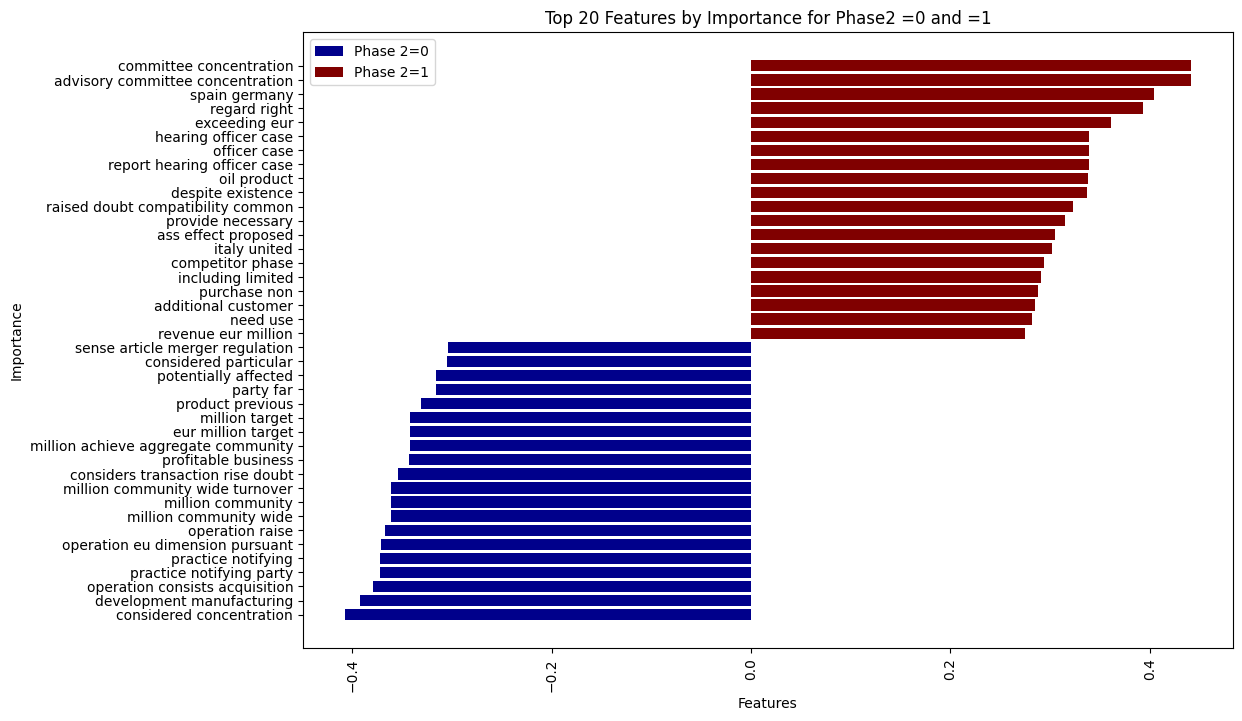

In [33]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='Phase 2=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='Phase 2=1')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Features by Importance for Phase2 =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [34]:
df_features_train.to_excel('../../../output/tables/features_svm_train_full_p2_v2.xlsx', index=True)

In [33]:
y_predict_test1

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [34]:
X_train

0      undertaking concerned combined aggregate world...
1      party overlapping activity area party ’ combin...
2      borden bakelite active production sale amino r...
3      celanese acetex signed arrangement agreement p...
4      interventional cardiology drug eluting stent i...
                             ...                        
152    annex analysis party ’ opportunity data submit...
153    transaction union dimension meaning article me...
154    transaction give rise vertically affected mark...
155    proposed transaction give rise seven horizonta...
156    analytical framework legal test assessment hor...
Name: text_clean, Length: 157, dtype: object